In [1]:
import numpy as np 
import cv2
import os
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense,Cropping2D,Activation,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation

In [2]:
direc = 'CK+48\CK+48'
CATEGORIES = os.listdir(direc)

In [3]:
def load_data():
    DATADIR = direc
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [4]:
data = load_data()
X = np.array([x[0] for x in data])
y = np.array([Y[1] for Y in data])

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

# Add data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 249/249 [00:00<00:00, 1311.24it/s]


# CNN Model:

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer='adam')

In [6]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='tb', histogram_freq=1, )

In [8]:
epochs = 35
batch_size = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ])

Epoch 1/35

25/25 [==============================] - 3s 54ms/step - loss: 1.8684 - accuracy: 0.2334 - precision: 0.1429 - recall: 0.0013 - auc: 0.6368 - val_loss: 1.8327 - val_accuracy: 0.2143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6599 - lr: 0.0010
Epoch 2/35
25/25 [==============================] - 1s 35ms/step - loss: 1.8095 - accuracy: 0.2704 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6712 - val_loss: 1.7823 - val_accuracy: 0.2143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6823 - lr: 0.0010
Epoch 3/35
25/25 [==============================] - 1s 34ms/step - loss: 1.7171 - accuracy: 0.3329 - precision: 0.8400 - recall: 0.0268 - auc: 0.7141 - val_loss: 1.6164 - val_accuracy: 0.3878 - val_precision: 1.0000 - val_recall: 0.0612 - val_auc: 0.7768 - lr: 0.0010
Epoch 4/35
25/25 [==============================] - 1s 34ms/step - loss: 1.4536 - accuracy: 0.4349 - precision: 0.8389 - recall: 0.1926 - auc: 0.8082 - val_loss: 1.3917 - 

In [9]:
model.save_weights('C:\\Users\\Nerdawy\\Downloads\\image-processing-main\\image-processing-main.h5')
model.save('amm.keras')

# plotting metrics.

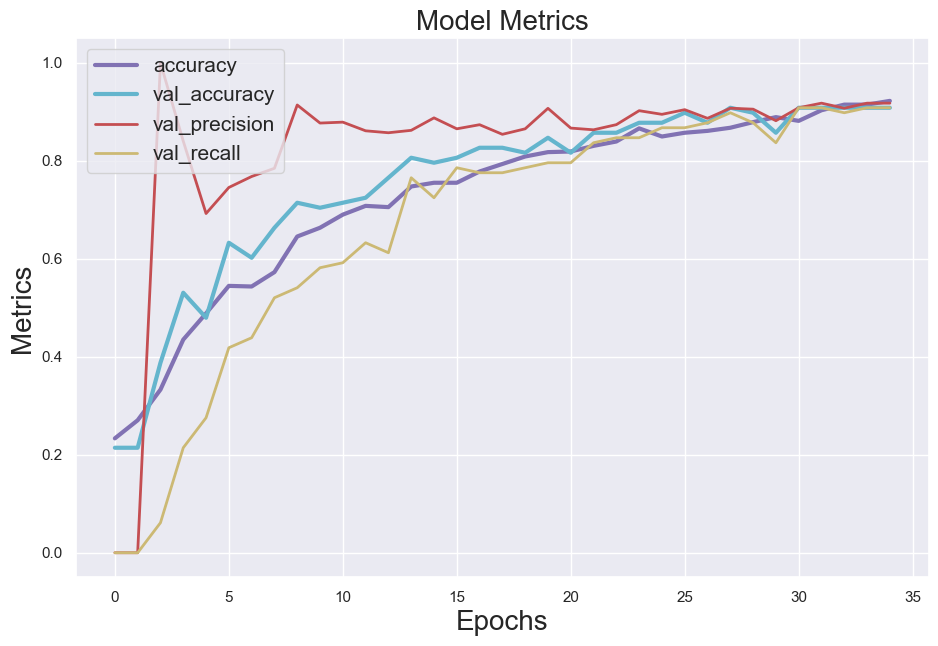

In [15]:
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(11,7))
plt.plot(history.history['accuracy'], color='m', linewidth=3.0)
plt.plot(history.history['val_accuracy'], color='c',linewidth=3.0 )
plt.plot(history.history['val_precision'], color='r',linewidth=2.0 )
plt.plot(history.history['val_recall'], color='y',linewidth=2.0 )
plt.title('Model Metrics',fontsize = 20 )
plt.ylabel('Metrics',fontsize = 20)
plt.xlabel('Epochs',fontsize = 20)
plt.legend(['accuracy', 'val_accuracy','val_precision','val_recall'], loc='upper left',fontsize = 15)
plt.show()

# confusion matrix:

In [ ]:
from keras.models import load_model
model = load_model('C:\\Users\\Nerdawy\\Downloads\\image-processing-main\\image-processing-main\\amm.keras')

In [17]:
test_results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_results[1] * 100:.2f}%")

val_results = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_results[1] * 100:.2f}%")

4/4 [==============================] - 0s 14ms/step - loss: 0.1205 - accuracy: 0.9394 - precision: 0.9388 - recall: 0.9293 - auc: 0.9988
Test Accuracy: 93.94%
4/4 [==============================] - 0s 13ms/step - loss: 0.3821 - accuracy: 0.9082 - precision: 0.9175 - recall: 0.9082 - auc: 0.9821
Validation Accuracy: 90.82%


In [12]:
y_pred = model.predict(X_test)
labels = ['angry','neutral','disgust','fear','happy','sad','surprise']
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tf.argmax(y_test, axis = 1), tf.argmax(y_pred, axis = 1))

4/4 [==============================] - 0s 10ms/step


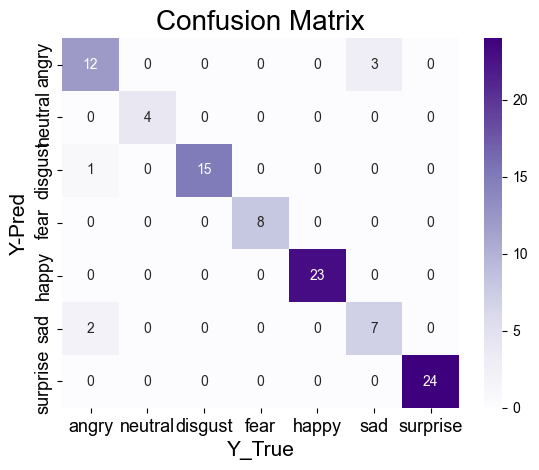

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
DetaFrame_cm = pd.DataFrame(cm, range(7), range(7))
p = sns.heatmap(DetaFrame_cm , cmap='Purples',annot=True)
p.set_title("Confusion Matrix",fontsize = 20)
sns.set(rc = {'figure.figsize':(8,7)})
sns.set(font_scale = 1)
p.set_yticklabels(labels, size = 13)
p.set_xticklabels(labels, size = 13)
p.set_xlabel("Y_True", fontsize = 15)
p.set_ylabel("Y-Pred", fontsize = 15)
plt.show()

# emotion recognetion

In [14]:
import cv2
import numpy as np
from keras.models import load_model

def preprocess_image(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, 0)
    # Resize the image to match the model input shape 
    img = cv2.resize(img, (48, 48))
    # Expand dimensions to make it compatible with the model input shape
    img = np.expand_dims(img, axis=0)
    # Normalize the pixel 
    img = img / 255.0
    return img

def predict_emotion(image_path, model):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Make the emotion prediction using the loaded model
    emotion_prediction = model.predict(processed_image)
    # Get the predicted emotion label
    predicted_label = np.argmax(emotion_prediction, axis=1)[0]
    # Map the predicted label to the corresponding emotion
    emotions = ['angry', 'neutral', 'disgust', 'fear', 'happy', 'sad', 'surprise']
    predicted_emotion = emotions[predicted_label]
    return predicted_emotion

# Load the trained model
model_path = 'C:\\Users\\Nerdawy\\Downloads\\image-processing-main\\image-processing-main.h5'
model = keras.models.load_model("C:\\Users\\Nerdawy\\Downloads\\image-processing-main\\image-processing-main\\amm.keras")

image_path_to_predict = 'happy.png'
predicted_emotion = predict_emotion(image_path_to_predict, model)
print(f'The predicted emotion is: {predicted_emotion}')
image_path_to_predict = 'surprise.png'
predicted_emotion = predict_emotion(image_path_to_predict, model)
print(f'The predicted emotion is: {predicted_emotion}')
image_path_to_predict = 'anger.png'
predicted_emotion = predict_emotion(image_path_to_predict, model)
print(f'The predicted emotion is: {predicted_emotion}')
image_path_to_predict = 'disgust.png'
predicted_emotion = predict_emotion(image_path_to_predict, model)
print(f'The predicted emotion is: {predicted_emotion}')
image_path_to_predict = 'fear.png'
predicted_emotion = predict_emotion(image_path_to_predict, model)
print(f'The predicted emotion is: {predicted_emotion}')


1/1 [==============================] - 0s 105ms/step
The predicted emotion is: happy
1/1 [==============================] - 0s 41ms/step
The predicted emotion is: surprise
1/1 [==============================] - 0s 42ms/step
The predicted emotion is: fear
1/1 [==============================] - 0s 37ms/step
The predicted emotion is: disgust
1/1 [==============================] - 0s 32ms/step
The predicted emotion is: fear
